<a href="https://colab.research.google.com/github/StephenScinocca/CNN/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

All of the different packages used for this notebook


In [1]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler

import numpy as np
import math 
from sklearn.model_selection import train_test_split

import torchvision
import torchvision.transforms as T
import torchvision.models as models

import matplotlib.pyplot as plt



# Functions

The following functions are called for my model, and they are:

## Setup of Model

### get_device()
  Checks to see what device (cpu or cuda) we are using

### to_device(data, device)
  Sets data to go to that device so we can use a GPU on google docs

In [2]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)


class ToDeviceLoader:
    def __init__(self,data,device):
        self.data = data
        self.device = device
        
    def __iter__(self):
        for batch in self.data:
            yield to_device(batch,self.device)
            
    def __len__(self):
        return len(self.data)


## In use by Model

### convolutions(in_channel,out_channel,kernel, pad = 0) 
Takes in starting channels, the ending channels, kernel size, and padding, then does a 2d convultion followed up by batch normalization

### training (epochs, optimizer, scheduler, criterion, trainloader, validloader, net) 
Takes in all of the information needed to train the convolutional neural net and trains it over the number of epochs past into it. At the end, it outputs the trained network as net, training loss, validation loss, and valodaition accuracy, witht he last 3 being lists of each loss and accuracy after each epoch.


### accuracy(net, loader, k = 1)
Taking in a trained network and a loader (trainloader, testloader, validloader), and k which is top k accuracy. The default is k = 1, or top 1 accuracy. It prints out the accuracy of the model at the end

### validation_a_and_l(net, validloader, criterion, epoch)

Gets the validation accuracy and the validation loss, is called after training is finishe don an epoch. It prints out the loss and accuracy to the console, and also returns the values. 

### plot_losses(val_losses, losses, epochs)

Plots the loss values of training and validation each epoch

### plot_accuracy(val_accuracy, epochs)

Plots the accuracy of the validation set each epoch

In [3]:
# for each convolutional layer, does the convolution then does batch normalization
def convolutions(in_channel,out_channel,kernel, pad = 0):
  layers = [nn.Conv2d(in_channel,out_channel,kernel, padding = pad),
             nn.BatchNorm2d(out_channel)]
  return nn.Sequential(*layers)

def training (epochs, optimizer, scheduler, criterion, trainloader, validloader, net):
  # tracking the training loss per epoch
  train_losses = []
  # tracking the validation loss per epoch
  val_losses = []
  # tracking the validation accuracy per epoch
  val_accuracy = []
  for epoch in range(epochs):
      #sets the network in training mode
      net.train()
      # running loss is the loss per epoch
      running_loss = 0.0
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data
          optimizer.zero_grad()
          # Gives you the outputs of each image in the batch
          outputs = net(inputs)
          # Calculates the loss of each 
          loss = criterion(outputs, labels)
          # Computes gradients for each parameter
          loss.backward()
          # Optimizer updates
          optimizer.step()
          # scheduelr updates
          scheduler.step()
          # tracks the loss of each item in the batch and adds them to running loss
          running_loss += loss.item()
          
      # prints out the training loss
      print('[{}] Training loss: {:.3f}'.format(epoch, running_loss / len(trainloader)))
      train_losses.append(running_loss / len(trainloader))
      val_l, val_a = validation_a_and_l(net, validloader, criterion, epoch)
      val_losses.append(val_l)
      val_accuracy.append(val_a)
  print("Finished Training")
  return (net, train_losses, val_losses, val_accuracy)


def accuracy(net, loader, k = 1):
  # number of correct predictions
  correct = 0
  # total number of labels (= 10000)
  total = 0
  # puts net in evaluation mode
  net.eval()
  with torch.no_grad():
    # loads in the data one batch at a time
    for data in loader:
        images, labels = data
        # outputs is the new output from running those images through the net
        outputs = net(images)
        # gets predictions from network (top k)
        _, predicted = torch.topk(outputs.data, k, dim = 1)
        # transpose the predictions
        predicted = predicted.t()
        # expand the labels to be the same length as the predictions
        labels_expanded = labels.view(1, -1).expand_as(predicted)
        # if any of the top k choices match with the label adds to correct
        topk_correct = (predicted == labels_expanded)
        # reshape topk_correct 
        topk_matched_truth = topk_correct.reshape(-1).float()
        # actually gets the number of correct lable sin the top k amount
        correct += topk_matched_truth.float().sum(dim=0, keepdim=True)
        # adds the total per batch
        total += labels.size(0)
  # prints the top k accuracy for the loader (usually testloader passed in)
  print("Top {} accuracy: {:.1f}%".format(k, 100 * int(correct) / total))


def validation_a_and_l(net, validloader, criterion, epoch):
  # number of correct predictions
  correct = 0
  # total number of labels (= 10000)
  total = 0
  # Running loss of validation
  running_loss = 0.0
  # puts net in evaluation mode
  net.eval()
  with torch.no_grad():
    # loads in the data one batch at a time
    for data in validloader:
        # gets the images and labels from that batch
        images, labels = data
        # outputs is the new output from running those images through the net
        outputs = net(images)
        # gets predictions from network (top 1)
        _, predicted = torch.max(outputs.data, 1)
        # updates the total each batch
        total += labels.size(0)
        # updates with the total number of correct predictions each batch
        correct += (predicted == labels).sum().item()
        # updated the valiadation loss each batch
        val_loss = criterion(outputs, labels)
        # updates running loss with the new valiation loss
        running_loss += val_loss
  # prints the valiadtion loss and accuracy in this epoch
  print('[{}] Validation loss: {:.3f}'.format(epoch, running_loss / len(validloader)))
  print("[{}] Accuracy of validation set: {:.1f}%".format(epoch, 100 * correct / total))
  # returns the validation loss and accuracy in this epoch
  return (running_loss / len(validloader), correct / total)

# plots the losses
def plot_losses(val_losses, train_losses, epochs):
  plt.plot(val_losses, label = "Validation")
  plt.plot(train_losses, label = "Training")
  plt.xlabel("epochs")
  plt.ylabel("Losses")
  plt.legend(title = "Losses")
  plt.title("Losses over {} epochs".format(epochs))

# plots the accuracy  
def plot_accuracy(accuracy, epochs):
  plt.plot(accuracy)
  plt.xlabel("epochs")
  plt.ylabel("Accuracy")
  plt.title("Validation Accuracy over {} epochs".format(epochs))


Now we do the transformations and load in the data. I transform the training set with RandomCrop with padding (mode is reflect), and randomHorizontalFlip. We also use RandomRotation(deg = 180), as this model was overfitting a lot without it. We also normalize with the mean and std found in CNN


In [4]:
transform1 = T.Compose(
    [
    # T.RandomRotation(degrees = (0,180)), # Can be added or removed
    T.RandomCrop(32, padding=4,padding_mode='reflect'),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.50695723, 0.48641145, 0.4407998), (0.25612617, 0.24619192, 0.2645457))]
    )

transform2 = T.Compose(
    [
#     T.RandomRotation(degrees = (0,180)),
    T.ToTensor(),
    T.Normalize((0.50695723, 0.48641145, 0.4407998), (0.25612617, 0.24619192, 0.2645457))]
    )

trainset = torchvision.datasets.CIFAR100(root='./data', train = True,
                                         download = True, transform = transform1)


testset = torchvision.datasets.CIFAR100(root='./data', train = False,
                                         download = True, transform = transform2)
batches=64




  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


## Split the validation and training set equally among classes


This section shows how to use test_train_split from scikit learn to get the indices of each class in the sets, randomly scramble them with SubsetRandomSampler, and then load them in using the sample condition to get your validation set and testing set

The validation set has 100 images of each class, as does the test set. The training set has 400 images of each class

In [5]:
# print((trainset.classes))
# This gives the indices of the training set
trainset_indices = [i for i in range(len(trainset))]
# With this we can get a split of the indices of trainset to be compelety evenly split between the classes
train_indices, val_indices, train_tar, val_tar = train_test_split(trainset_indices, trainset.targets, test_size = 0.2, stratify = trainset.targets, random_state=78)
# this splits the subsets randomly for training samples
train_sampler = SubsetRandomSampler(train_indices)
# this splits the subsets randomly for validation samples
val_sampler = SubsetRandomSampler(val_indices)
#load them using dataloader, and use sampler with the indicies to know which ones have the correct split
trainloader = DataLoader(trainset, num_workers=2,pin_memory=True, shuffle=False, batch_size=batches, sampler=train_sampler)
validloader = DataLoader(trainset, num_workers=2,pin_memory=True, shuffle=False, batch_size=batches, sampler=val_sampler)
testloader = DataLoader(testset, batch_size=batches, num_workers=2,pin_memory=True, shuffle=False)

device = get_device()
print(device)

trainloader = ToDeviceLoader(trainloader,device)
validloader = ToDeviceLoader(validloader,device)
testloader = ToDeviceLoader(testloader,device)

cuda


Load in resnet 

In [6]:
resnet18 = models.resnet18()
net = to_device(resnet18,device) 

Set the variables needed for the model to run

In [7]:
epochs = 75

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.1, momentum = 0.9)
# scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.9, last_epoch=- 1, verbose=True)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.001, epochs = epochs, steps_per_epoch=len(trainloader))

Run the model with training!

In [8]:
net, train_losses, val_losses, val_accuracy = training(epochs, optimizer, scheduler, criterion, trainloader, validloader, net)

[0] Training loss: 6.389
[0] Validation loss: 5.581
[0] Accuracy of validation set: 4.8%
[1] Training loss: 4.986
[1] Validation loss: 4.528
[1] Accuracy of validation set: 8.0%
[2] Training loss: 4.269
[2] Validation loss: 4.069
[2] Accuracy of validation set: 10.9%
[3] Training loss: 3.946
[3] Validation loss: 3.827
[3] Accuracy of validation set: 13.4%
[4] Training loss: 3.738
[4] Validation loss: 3.652
[4] Accuracy of validation set: 15.0%
[5] Training loss: 3.578
[5] Validation loss: 3.514
[5] Accuracy of validation set: 17.6%
[6] Training loss: 3.437
[6] Validation loss: 3.401
[6] Accuracy of validation set: 19.0%
[7] Training loss: 3.312
[7] Validation loss: 3.280
[7] Accuracy of validation set: 21.1%
[8] Training loss: 3.198
[8] Validation loss: 3.174
[8] Accuracy of validation set: 22.2%
[9] Training loss: 3.078
[9] Validation loss: 3.086
[9] Accuracy of validation set: 24.2%
[10] Training loss: 2.990
[10] Validation loss: 3.004
[10] Accuracy of validation set: 26.4%
[11] Trai

Get the top 1 and top 5 accuracy of the model trained

In [9]:
accuracy(net, testloader, k = 1)
accuracy(net, testloader, k = 5)

Top 1 accuracy: 47.7%
Top 5 accuracy: 75.3%


Plot the loss of the training and validation sets

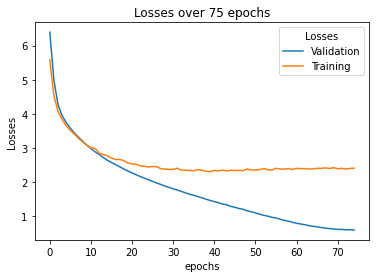

In [11]:
plot_losses(train_losses, val_losses, epochs)

Plot the validation accuracy each epoch

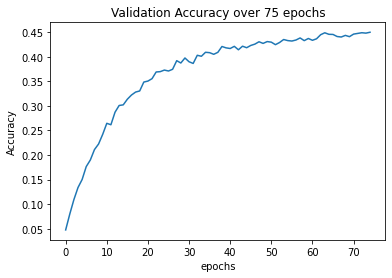

In [12]:
plot_accuracy(val_accuracy, epochs)

This next part was used for testing different variations of the model with different learning rates and such. I have left it to check for different max learning rates for the OneCycleLR scheduler

In [13]:
epochs = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.1, momentum = 0.9)

scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.01, epochs = epochs, steps_per_epoch=len(trainloader))

learning_rates = [0.001, 0.005, 0.01]

losses = np.zeros([len(learning_rates),epochs])
val_losses = np.zeros([len(learning_rates),epochs])
val_acc = np.zeros([len(learning_rates),epochs])
nets = []

for i in range(len(learning_rates)):
  resnet18 = models.resnet18()
  testnet = to_device(resnet18,device) 
  optimizer = optim.SGD(net.parameters(), lr = learning_rates[i], momentum = 0.9)
  scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr = learning_rates[i], epochs = epochs, steps_per_epoch=len(trainloader))
  n, train_losses[i], val_losses[i], val_acc[i] = training(epochs, optimizer, scheduler, criterion, trainloader, validloader, testnet)
  nets.append(n)
 


[0] Training loss: 5.484
[0] Validation loss: 4.048
[0] Accuracy of validation set: 10.5%
[1] Training loss: 3.802
[1] Validation loss: 3.609
[1] Accuracy of validation set: 15.5%
[2] Training loss: 3.491
[2] Validation loss: 3.368
[2] Accuracy of validation set: 19.1%
[3] Training loss: 3.287
[3] Validation loss: 3.248
[3] Accuracy of validation set: 21.5%
[4] Training loss: 3.156
[4] Validation loss: 3.192
[4] Accuracy of validation set: 22.6%
Finished Training
[0] Training loss: 4.622
[0] Validation loss: 3.708
[0] Accuracy of validation set: 13.1%
[1] Training loss: 3.473
[1] Validation loss: 3.294
[1] Accuracy of validation set: 20.4%
[2] Training loss: 3.093
[2] Validation loss: 3.008
[2] Accuracy of validation set: 25.6%
[3] Training loss: 2.782
[3] Validation loss: 2.792
[3] Accuracy of validation set: 29.3%
[4] Training loss: 2.510
[4] Validation loss: 2.584
[4] Accuracy of validation set: 34.3%
Finished Training
[0] Training loss: 4.361
[0] Validation loss: 3.691
[0] Accuracy

Plot the top 1 and top 5 accuracy of each network

In [14]:
for net in nets:
  accuracy(net, testloader, k = 1)
  accuracy(net, testloader, k = 5)

Top 1 accuracy: 25.4%
Top 5 accuracy: 53.1%
Top 1 accuracy: 37.6%
Top 5 accuracy: 68.3%
Top 1 accuracy: 39.6%
Top 5 accuracy: 70.2%


Plot the training and validation losses of each network

Text(0.5, 1.0, 'Max Learning Rates Loss')

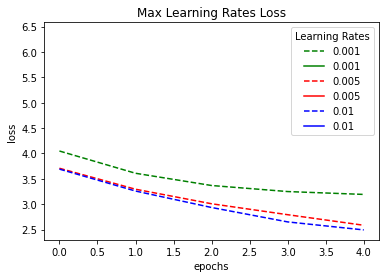

In [18]:
colours = ['g', 'r', 'b', 'c']
for i in range(len(learning_rates)):
  plt.plot(val_losses[i], '{}--'.format(colours[i]), label = learning_rates[i])
  plt.plot(train_losses[i], '{}-'.format(colours[i]), label = learning_rates[i])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(title = "Learning Rates")
plt.title("Max Learning Rates Loss")